# Convolutions

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(t-\tau)g(\tau)d\tau $$

Where _f_ is the image (1D here for simplicity) and _g_ a convolutional filter. It's applied as a dot product of a sliding window over the input data.

### Additional references:
https://en.wikipedia.org/wiki/Convolution <br>
https://en.wikipedia.org/wiki/Convolutional_neural_network <br>
Stanford notes on CNN: https://cs231n.github.io/convolutional-networks/ <br>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" alt="1D Convolutions" style="width:600px;"/>
<br>
<br>
<img src="https://blog.roboflow.com/content/images/2020/07/grayscale_aug.gif" alt="Conv2D" style="width:800px; "/>
<br>
<br>
<img src="https://cs231n.github.io/assets/cnn/convnet.jpeg" alt="CNN" style="width:800px; "/>

In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import *

tf.config.experimental.set_visible_devices([], 'GPU') # force CPU usage
tf.version.VERSION

'2.5.0'

In [2]:
list_of_files = ['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00002-of-00128']
list_of_files

['/scratch/snx3000/datasets/imagenet/ILSVRC2012_1k/validation/validation-00002-of-00128']

In [3]:
image_shape = (224, 224)

def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize(image, image_shape) / 255
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image, label

In [4]:
dataset = tf.data.TFRecordDataset(list_of_files)
dataset = dataset.map(decode)
dataset = dataset.batch(1024)

Image shape: (391, 224, 224, 3) Unique Labels: 326


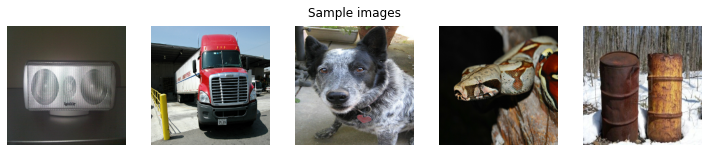

In [5]:
for images, labels in dataset.take(1):
    print('Image shape:', images.shape, 'Unique Labels:', len(np.unique(labels)))

plot_grid(images[:5].numpy(), 'Sample images', rows=1, figsize=(10, 2))
plt.show()

# Let's extract 8x8-pixel patches of the images

((391, 55, 55, 192), (5, 8, 8, 3))

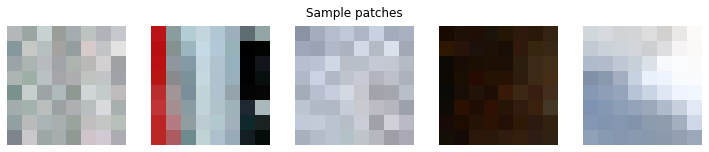

In [6]:
patches = tf.image.extract_patches(images=images,
                                   sizes=[1, 8, 8, 1],
                                   strides=[1, 4, 4, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID').numpy()

samples = patches[:5, 27, 27, :].reshape([-1, 8, 8, 3])
plot_grid(samples, 'Sample patches', norm_axis=None, rows=1, figsize=(10, 2))

patches.shape, samples.shape

# What are the principal components of these patches?

In [7]:
from sklearn.decomposition import PCA

vec_patches = patches.reshape([-1, 8*8*3])
print('Vectorised patches:', vec_patches.shape)

pca = PCA(n_components=25, whiten=True, svd_solver='arpack')
pca.fit(vec_patches)
bases = pca.components_.T

print('PCA bases:', bases.shape)

Vectorised patches: (1182775, 192)
PCA bases: (192, 25)


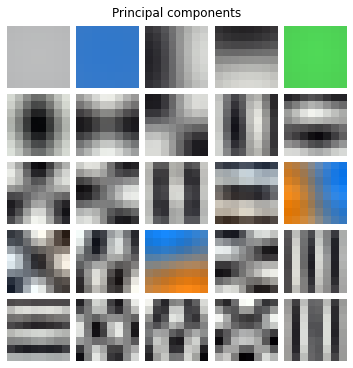

In [8]:
plot_grid(bases.reshape([8, 8, 3, pca.n_components]).transpose(3, 0, 1, 2), 'Principal components', figsize=(4.8, 5))
plt.show()

# Convolution = patches * components

In [9]:
dotprod = patches[:9].dot(bases)
dotprod.shape

(9, 55, 55, 25)

In [10]:
patches.shape, bases.shape, dotprod[5, ..., :5].transpose([2, 0, 1]).shape

((391, 55, 55, 192), (192, 25), (5, 55, 55))

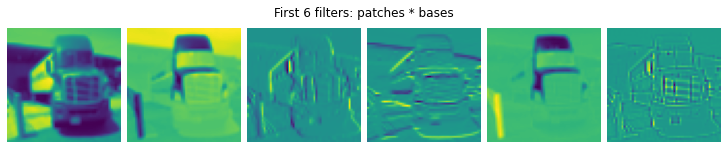

In [11]:
# first 6 filters, on 2nd image
plot_grid(dotprod[1, ..., :6].transpose([2, 0, 1]), 'First 6 filters: patches * bases', rows=1, figsize=(10, 2))
plt.show()

## TF Conv2d

In [12]:
conv_out = tf.nn.conv2d(images[:9],
                        bases.reshape([8, 8, 3, pca.n_components]),
                        strides=[1, 1, 1, 1], padding='VALID').numpy()
conv_out.shape

(9, 217, 217, 25)

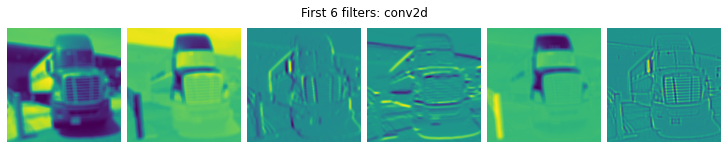

In [13]:
# first 6 filters, on 2nd image
plot_grid(conv_out[1, ..., :6].transpose([2, 0, 1]), 'First 6 filters: conv2d', rows=1, figsize=(10, 2))
plt.show()

# Exercise: plot and check the difference between the dot product and conv2d
Note: you might need to align 'strides' in either one to match the other

Docs: https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

In [14]:
# diff = ...
# print(diff.shape)
# plot_grid(diff[1, ..., :6].transpose([2, 0, 1]), 'conv2d vs. dotprod', rows=1, norm_axis=None, figsize=(10, 2))
# plt.show()

# _ = pd.Series(diff.ravel()).hist(bins=100, log=True)
# _ = plt.title('Distribution of errors')

# 2: try using padding='SAME' What happens to PCA then?
# 3: Is it possible to reconstruct the patches from the convolutional output?

# ResNet50

(7, 7, 3, 64)

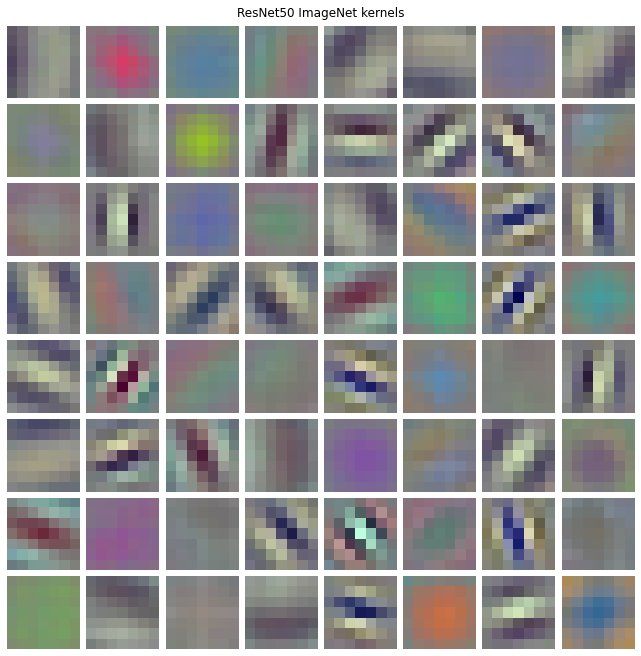

In [15]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

rn50 = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=True, classes=1000,
    weights='/scratch/snx3000/dealmeih/models/imagenet/resnet50v2_weights_tf_dim_ordering_tf_kernels.h5'
)
w1 = rn50.weights[0].numpy()

plot_grid(w1.transpose(3, 0, 1, 2), 'ResNet50 ImageNet kernels', figsize=(8.8, 9))
w1.shape

(7, 7, 3, 64)

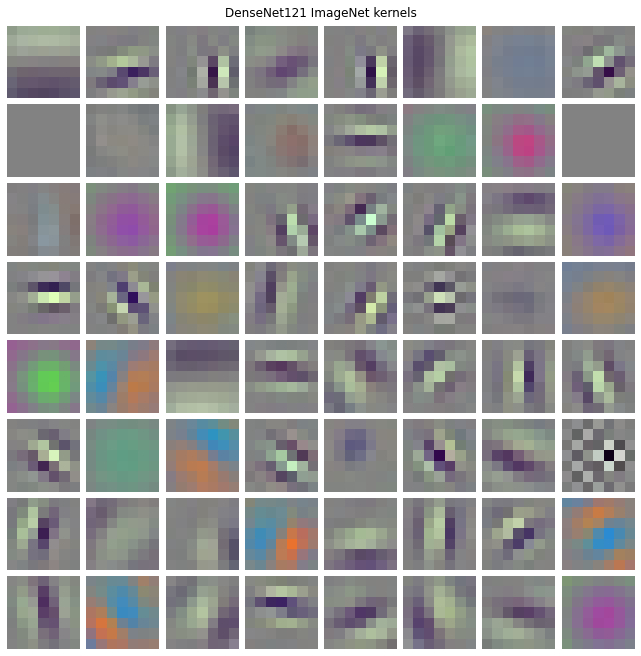

In [16]:
dn121 = tf.keras.applications.densenet.DenseNet121(
    include_top=True, classes=1000,
    weights='/scratch/snx3000/dealmeih/models/imagenet/densenet121_weights_tf_dim_ordering_tf_kernels.h5'
)
w1 = dn121.weights[0].numpy()

plot_grid(w1.transpose(3, 0, 1, 2), 'DenseNet121 ImageNet kernels', figsize=(8.8, 9))  #, norm_axis=(1,2,3)
w1.shape